In [24]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, year
from joblib import Parallel, delayed

In [25]:
# Reading the dataset
df = pd.read_csv('/content/2000-2021 SINGLE TURKEY FIRE_M-C61_214067.csv', dtype={'version': str})

In [26]:
# View a few elements of the dataset
df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,36.8527,35.3594,306.0,2.1,1.4,2000-11-01,815,Terra,MODIS,60,6.03,294.4,13.2,D,0.0
1,40.5441,35.1786,307.8,1.1,1.0,2000-11-02,857,Terra,MODIS,66,6.03,296.0,5.8,D,0.0
2,40.1473,35.0444,305.3,1.1,1.0,2000-11-02,857,Terra,MODIS,46,6.03,293.5,4.3,D,0.0
3,40.5421,35.1909,310.0,1.1,1.0,2000-11-02,857,Terra,MODIS,69,6.03,296.1,7.3,D,0.0
4,41.2569,31.4172,307.9,1.1,1.0,2000-11-02,857,Terra,MODIS,0,6.03,290.4,8.0,D,2.0


In [27]:
# Check data info
df.info()

# Handle missing values
df = df.dropna()

# Display columns
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211309 entries, 0 to 211308
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   latitude    211309 non-null  float64
 1   longitude   211309 non-null  float64
 2   brightness  211309 non-null  float64
 3   scan        211309 non-null  float64
 4   track       211309 non-null  float64
 5   acq_date    211309 non-null  object 
 6   acq_time    211309 non-null  int64  
 7   satellite   211309 non-null  object 
 8   instrument  211309 non-null  object 
 9   confidence  211309 non-null  int64  
 10  version     211309 non-null  object 
 11  bright_t31  211309 non-null  float64
 12  frp         211309 non-null  float64
 13  daynight    211309 non-null  object 
 14  type        205918 non-null  float64
dtypes: float64(8), int64(2), object(5)
memory usage: 24.2+ MB


Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'type'],
      dtype='object')

In [28]:
# Remove outliers using IQR
# Calculate Q1 and Q3 for numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_filtered = df[~((df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)).any(axis=1)]

print(f"Original data shape: {df.shape}")
print(f"Filtered data shape: {df_filtered.shape}")

df = df_filtered.copy() # Copy the data with no outliers

Original data shape: (205918, 15)
Filtered data shape: (133412, 15)


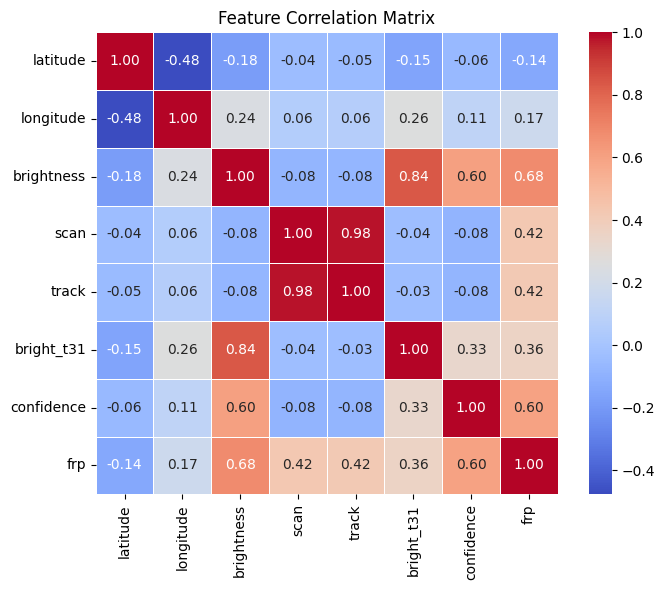

In [29]:
# Compute correlation matrix
corr = df[['latitude', 'longitude', 'brightness', 'scan', 'track', 'bright_t31', 'confidence', 'frp']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [30]:
# Select features and target

features = ['brightness', 'scan', 'track','confidence']
target = 'frp'

X = df[features]
y = df[target]

In [31]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate Linear Regression
print("Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2 Score:", r2_score(y_test, y_pred_lr))

Linear Regression Performance:
MAE: 4.727006291029031
RMSE: 6.1745663718829285
R2 Score: 0.7549565415424608


In [33]:
# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
print("Random Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2 Score:", r2_score(y_test, y_pred_rf))


Random Forest Performance:
MAE: 2.822545196205912
RMSE: 4.090959301059221
R2 Score: 0.8924326413419457


In [34]:
importances = rf.feature_importances_
features = X.columns

# Show feature importances
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4f}")


brightness: 0.1537
scan: 0.1644
track: 0.1450
confidence: 0.5369


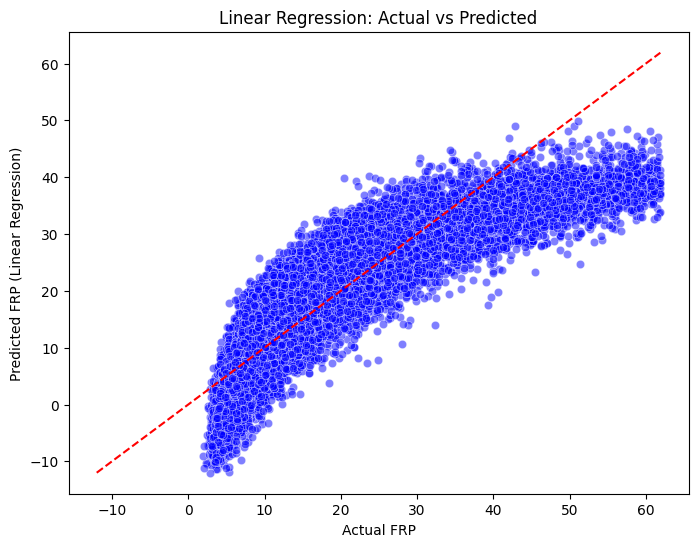

In [35]:
# Plot Linear Regression Results
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.5, color="blue")
# Plot perfect prediction line
min_val = min(y_test.min(), y_pred_lr.min())
max_val = max(y_test.max(), y_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Perfect Prediction Line')
plt.xlabel("Actual FRP")
plt.ylabel("Predicted FRP (Linear Regression)")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

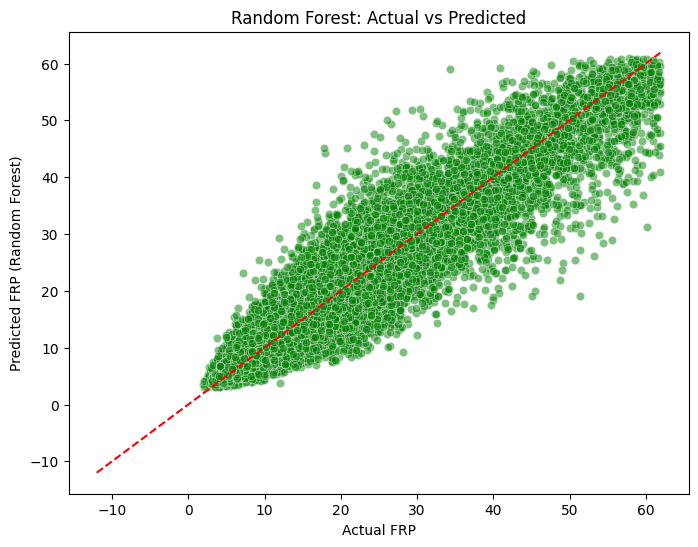

In [36]:
# Plot Random Forest Results
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, color="green")
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Perfect Prediction Line')
plt.xlabel("Actual FRP")
plt.ylabel("Predicted FRP (Random Forest)")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

Parallel Processing

Use PySpark

In [37]:
# Create Spark session
spark = SparkSession.builder.appName("TurkeyFireAnalysis").getOrCreate()

spark_df= spark.createDataFrame(df)
spark_df.show()


+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
|latitude|longitude|brightness|scan|track|  acq_date|acq_time|satellite|instrument|confidence|version|bright_t31| frp|daynight|type|
+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
| 36.8527|  35.3594|     306.0| 2.1|  1.4|2000-11-01|     815|    Terra|     MODIS|        60|   6.03|     294.4|13.2|       D| 0.0|
| 40.5441|  35.1786|     307.8| 1.1|  1.0|2000-11-02|     857|    Terra|     MODIS|        66|   6.03|     296.0| 5.8|       D| 0.0|
| 40.1473|  35.0444|     305.3| 1.1|  1.0|2000-11-02|     857|    Terra|     MODIS|        46|   6.03|     293.5| 4.3|       D| 0.0|
| 40.5421|  35.1909|     310.0| 1.1|  1.0|2000-11-02|     857|    Terra|     MODIS|        69|   6.03|     296.1| 7.3|       D| 0.0|
| 39.1096|  33.9391|     324.5| 1.0|  1.0|2000-11-02|     858|    Ter

In [38]:
# Perform parallel aggregation (sum) on the 'brightness' column
total_brightness = spark_df.agg(sum('brightness')).collect()[0][0]

print(f"Total Brightness: {total_brightness}")

Total Brightness: 43095857.200000085


In [39]:
# Extract the year from 'acq_date' and create a new 'Year' column
spark_df_with_year = spark_df.withColumn("Year", year("acq_date"))

# Group by 'Year' and calculate the sum of 'brightness' for each year
final_result = spark_df_with_year.groupBy("Year").agg(sum("brightness").alias("total_brightness_by_year"))

# Show the result
final_result.orderBy("Year").show()

+----+------------------------+
|Year|total_brightness_by_year|
+----+------------------------+
|2000|      144385.09999999995|
|2001|       1076852.200000003|
|2002|       1468170.900000001|
|2003|      1602603.1999999997|
|2004|      1815037.6000000031|
|2005|       1791790.000000001|
|2006|      1912221.1000000015|
|2007|       1770349.800000001|
|2008|       1240878.200000004|
|2009|      3881693.4999999977|
|2010|       2773047.800000015|
|2011|       3911255.799999999|
|2012|      1499348.8000000012|
|2013|        2445505.60000001|
|2014|      1418871.4999999988|
|2015|               3668936.3|
|2016|      2947289.4000000004|
|2017|      1945874.3000000073|
|2018|      1758386.6999999958|
|2019|      1980234.5999999929|
+----+------------------------+
only showing top 20 rows



In [40]:
# Modify Linear Regression Training and Prediction with joblib
print("Linear Regression Performance (Parallel):")
lr_parallel = LinearRegression()
lr_parallel.fit(X_train, y_train)

# Parallel prediction
n_cores = -1  # Use all available CPU cores
y_pred_lr_parallel = Parallel(n_jobs=n_cores)(delayed(lr_parallel.predict)(X_test.iloc[i:i+1])
for i in range(len(X_test)))
y_pred_lr_parallel = np.concatenate(y_pred_lr_parallel)


# Evaluate Linear Regression
print("MAE:", mean_absolute_error(y_test, y_pred_lr_parallel))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr_parallel)))
print("R2 Score:", r2_score(y_test, y_pred_lr_parallel))

print("\nRandom Forest Performance (Parallel):")
rf_parallel = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=n_cores)
rf_parallel.fit(X_train, y_train)

# Parallel prediction (RandomForestRegressor's predict also supports n_jobs)
y_pred_rf_parallel = rf_parallel.predict(X_test)

# Evaluate Random Forest
print("MAE:", mean_absolute_error(y_test, y_pred_rf_parallel))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf_parallel)))
print("R2 Score:", r2_score(y_test, y_pred_rf_parallel))

Linear Regression Performance (Parallel):
MAE: 4.7270062910290305
RMSE: 6.1745663718829285
R2 Score: 0.7549565415424608

Random Forest Performance (Parallel):
MAE: 2.822545196205912
RMSE: 4.090959301059221
R2 Score: 0.8924326413419457


In [41]:
# Record training time for Linear Regression (sequential)
start_time = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
end_time = time.time()
lr_train_time_sequential = end_time - start_time

# Record training time for Random Forest (sequential)
start_time = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
end_time = time.time()
rf_train_time_sequential = end_time - start_time

# The fit time will be the same as the sequential version.
lr_train_time_parallel = lr_train_time_sequential

# Record training time for Random Forest (parallel)
start_time = time.time()
rf_parallel = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=n_cores)
rf_parallel.fit(X_train, y_train)
end_time = time.time()
rf_train_time_parallel = end_time - start_time

# Print the training times
print(f"Linear Regression Training Time (Sequential): {lr_train_time_sequential:.4f} seconds")
print(f"Linear Regression Training Time (Parallel): {lr_train_time_parallel:.4f} seconds (Fit is sequential)")
print(f"Random Forest Training Time (Sequential): {rf_train_time_sequential:.4f} seconds")
print(f"Random Forest Training Time (Parallel): {rf_train_time_parallel:.4f} seconds")

Linear Regression Training Time (Sequential): 0.0195 seconds
Linear Regression Training Time (Parallel): 0.0195 seconds (Fit is sequential)
Random Forest Training Time (Sequential): 25.2703 seconds
Random Forest Training Time (Parallel): 19.2423 seconds


In [42]:
# Calculate and print accuracy metrics for sequential Linear Regression
print("Linear Regression Performance (Sequential):")
mae_lr_sequential = mean_absolute_error(y_test, y_pred_lr)
mse_lr_sequential = mean_squared_error(y_test, y_pred_lr)
rmse_lr_sequential = np.sqrt(mse_lr_sequential)
r2_lr_sequential = r2_score(y_test, y_pred_lr)
print("MAE:", mae_lr_sequential)
print("RMSE:", rmse_lr_sequential)
print("R2 Score:", r2_lr_sequential)

# Calculate and print accuracy metrics for parallel Linear Regression
print("\nLinear Regression Performance (Parallel):")
mae_lr_parallel = mean_absolute_error(y_test, y_pred_lr_parallel)
mse_lr_parallel = mean_squared_error(y_test, y_pred_lr_parallel)
rmse_lr_parallel = np.sqrt(mse_lr_parallel)
r2_lr_parallel = r2_score(y_test, y_pred_lr_parallel)
print("MAE:", mae_lr_parallel)
print("RMSE:", rmse_lr_parallel)
print("R2 Score:", r2_lr_parallel)

# Calculate and print accuracy metrics for sequential Random Forest
print("\nRandom Forest Performance (Sequential):")
mae_rf_sequential = mean_absolute_error(y_test, y_pred_rf)
mse_rf_sequential = mean_squared_error(y_test, y_pred_rf)
rmse_rf_sequential = np.sqrt(mse_rf_sequential)
r2_rf_sequential = r2_score(y_test, y_pred_rf)
print("MAE:", mae_rf_sequential)
print("RMSE:", rmse_rf_sequential)
print("R2 Score:", r2_rf_sequential)

# Calculate and print accuracy metrics for parallel Random Forest
print("\nRandom Forest Performance (Parallel):")
mae_rf_parallel = mean_absolute_error(y_test, y_pred_rf_parallel)
mse_rf_parallel = mean_squared_error(y_test, y_pred_rf_parallel)
rmse_rf_parallel = np.sqrt(mse_rf_parallel)
r2_rf_parallel = r2_score(y_test, y_pred_rf_parallel)
print("MAE:", mae_rf_parallel)
print("RMSE:", rmse_rf_parallel)
print("R2 Score:", r2_rf_parallel)

Linear Regression Performance (Sequential):
MAE: 4.727006291029031
RMSE: 6.1745663718829285
R2 Score: 0.7549565415424608

Linear Regression Performance (Parallel):
MAE: 4.7270062910290305
RMSE: 6.1745663718829285
R2 Score: 0.7549565415424608

Random Forest Performance (Sequential):
MAE: 2.822545196205912
RMSE: 4.090959301059221
R2 Score: 0.8924326413419457

Random Forest Performance (Parallel):
MAE: 2.822545196205912
RMSE: 4.090959301059221
R2 Score: 0.8924326413419457


In [48]:
# Create a dictionary to store the results
results = {
    'Model': ['Linear Regression', 'Linear Regression', 'Random Forest', 'Random Forest'],
    'Processing': ['Sequential', 'Parallel', 'Sequential', 'Parallel'],
    'MAE': [mae_lr_sequential, mae_lr_parallel, mae_rf_sequential, mae_rf_parallel],
    'RMSE': [rmse_lr_sequential, rmse_lr_parallel, rmse_rf_sequential, rmse_rf_parallel],
    'R2 Score': [r2_lr_sequential, r2_lr_parallel, r2_rf_sequential, r2_rf_parallel],
    'Training Time (s)': [lr_train_time_sequential, lr_train_time_parallel, rf_train_time_sequential, rf_train_time_parallel]
}

# Create a pandas DataFrame from the dictionary
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df.head()

,Model,Processing,MAE,RMSE,R2 Score,Training Time (s)
0,Linear Regression,Sequential,4.727006,6.174566,0.754957,0.019544
1,Linear Regression,Parallel,4.727006,6.174566,0.754957,0.019544
2,Random Forest,Sequential,2.822545,4.090959,0.892433,25.270313
3,Random Forest,Parallel,2.822545,4.090959,0.892433,19.242321


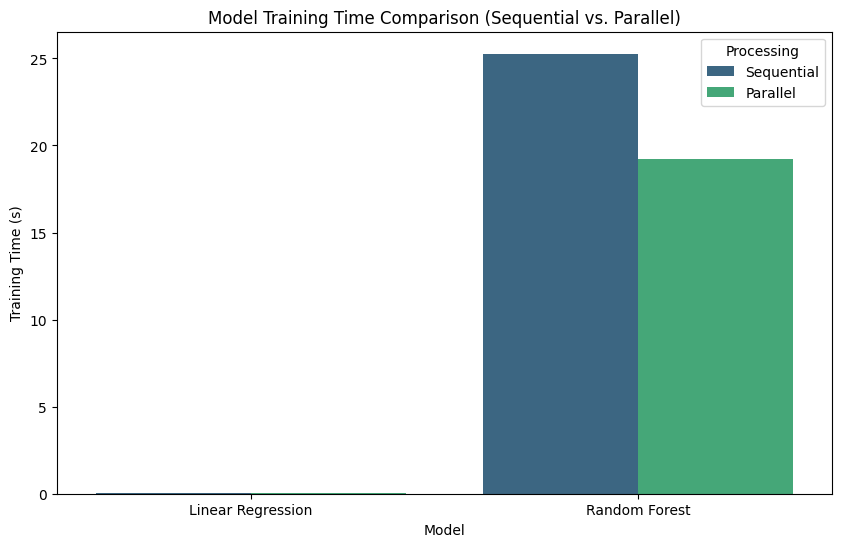

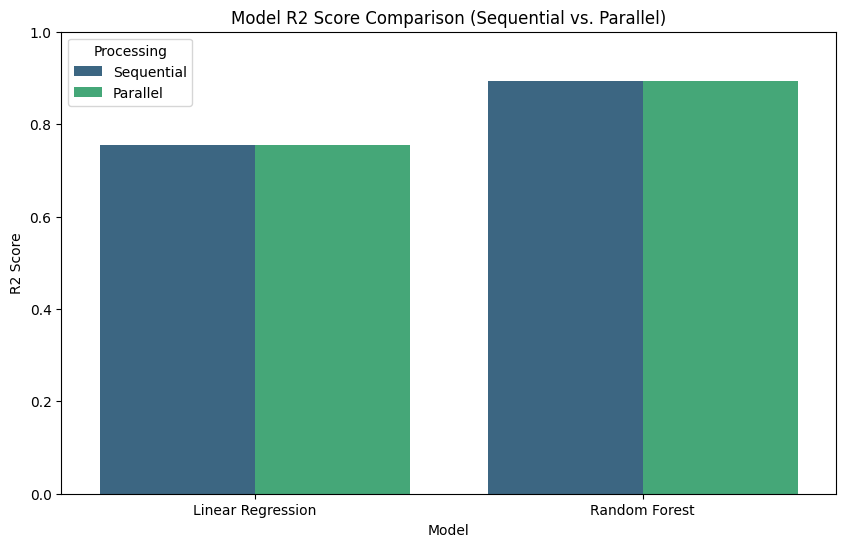

In [44]:
# Plot Training Time Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training Time (s)', hue='Processing', data=results_df, palette='viridis')
plt.title('Model Training Time Comparison (Sequential vs. Parallel)')
plt.ylabel('Training Time (s)')
plt.xlabel('Model')
plt.show()

# Plot R2 Score Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2 Score', hue='Processing', data=results_df, palette='viridis')
plt.title('Model R2 Score Comparison (Sequential vs. Parallel)')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()